# CSE527 Homework 4
**Due date: 11:59 pm EST on Nov. 1, 2022 (Tue.)**

In this semester, we will use Google Colab for the assignments, which allows us to utilize resources that some of us might not have in their local machines such as GPUs. You will need to use your Stony Brook (*.stonybrook.edu) account for coding and Google Drive to save your results.

## Google Colab Tutorial
---
Go to https://colab.research.google.com/notebooks/, you will see a tutorial named "Welcome to Colaboratory" file, where you can learn the basics of using google colab.

Settings used for assignments: ***Edit -> Notebook Settings -> Runtime Type (Python 3)***.


## Description
---
This project is an introduction to deep learning tools for computer vision. You will design and train deep convolutional networks for scene recognition using [PyTorch](http://pytorch.org). You can visualize the
structure of the network with [mNeuron] (http://vision03.csail.mit.edu/cnn_art/index.html)

In Problem 1 of the project you will train a deep convolutional network from scratch to recognize scenes. The starter codes gives you methods to load data and display them. You will need to define a simple network architecture and add jittering, normalization, and regularization to increase recognition accuracy to 50, 60, or perhaps 70%. Unfortunately, we only have 2,400 training examples so it doesn't seem possible to train a network from scratch which outperforms hand-crafted features

For Problem 2 you will instead fine-tune a pre-trained deep network to achieve about 85% accuracy on the task. We will use the pretrained AlexNet network which was not trained to recognize scenes at all. 

These two approaches represent the most common approaches to recognition problems in computer vision today -- train a deep network from scratch if you have enough data (it's not always obvious whether or not you do), and if you cannot then instead fine-tune a pre-trained network.

There are 2 problems in this homework with a total of 120 points including 20 bonus points. Be sure to read **Submission Guidelines** below. They are important. For the problems requiring text descriptions, you might want to add a markdown block for that.

## Dataset
---
Save the [dataset(click me)](https://drive.google.com/open?id=1NWC3TMsXSWN2TeoYMCjhf2N1b-WRDh-M) into your working folder in your Google Drive for this homework. <br>
Under your root folder, there should be a folder named "data" (i.e. XXX/Surname_Givenname_SBUID/data) containing the images.

## Some Tutorials (PyTorch)
---
- You will be using PyTorch for deep learning toolbox (follow the [link](http://pytorch.org) for installation).
- For PyTorch beginners, please read this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) before doing your homework.
- Feel free to study more tutorials at http://pytorch.org/tutorials/.
- Find cool visualization here at http://playground.tensorflow.org.




In [ ]:
# import packages here
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import random 
import time

import torch
import torchvision
import torchvision.transforms as transforms

from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Mount your google drive where you've saved your assignment folder
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# Replace '------' with the path such that "Surname_Givenname_SBUID_hw*" is your working directory
%cd '/content/gdrive/MyDrive/Basak_Hritam_114783055_HW4/'

/content/gdrive/MyDrive/Basak_Hritam_114783055_HW4


## Problem 0: Loading and Preprocessing data
---
(0 point) In this part, you are provided with a function that loads data into minibatches for training and testing in PyTorch. However, some preprocessing parts are missing. Your will need to implement them when doing Problem 1.

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------

def set_random_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     random.seed(seed)
     torch.backends.cudnn.deterministic = True
set_random_seed(0)

class_names = [name[13:] for name in glob.glob('./data/train/*')]
class_names = dict(zip(range(len(class_names)), class_names))
print("class_names: %s " % class_names)

def load_dataset(path, img_size, num_per_class=-1, batch_size=16, shuffle=False,
           augment=False, is_color=False, zero_centered=False):    
    data = []
    labels = []    
    channel_num = 3 if is_color else 1
        
    # read images and resizing
    for id, class_name in class_names.items():
        print("Loading images from class: %s" % id)
        img_path_class = glob.glob(path + class_name + '/*.jpg')
        if num_per_class > 0:
            img_path_class = img_path_class[:num_per_class]
        labels.extend([id]*len(img_path_class))
        for filename in img_path_class:
            if is_color:
                img = cv2.imread(filename)
            else:
                img = cv2.imread(filename, 0)
            
            # resize the image
            img = cv2.resize(img, img_size, cv2.INTER_LINEAR)
            
            if is_color:
                img = np.transpose(img, [2, 0, 1])
            
            # norm pixel values to [-1, 1]
            data.append(img.astype(np.float)/255*2-1)
            
    ##########--WRITE YOUR CODE HERE--##########
    # Data Augmentation 
    if augment: 
        #pass
        
        augmentation = [cv2.flip(img, 1) for img in data]
        

        data.extend(augmentation)
        labels.extend(labels)


    ##########-------END OF CODE-------##########    
    
    ##########--WRITE YOUR CODE HERE--##########
    # Data Normalization
    if zero_centered:
        #pass
        l = len(data)
        for k in range (l):
          mu, _ = cv2.meanStdDev(data[k])
          data[k] -= mu

        
    ##########-------END OF CODE-------##########
         
    # randomly permute (this step is important for training)
    if shuffle:
        bundle = list(zip(data, labels))
        random.shuffle(bundle)
        data, labels = zip(*bundle)
    
    # divide data into minibatches of TorchTensors
    if batch_size > 1:
        batch_data = []
        batch_labels = []
         
        for i in range(int(len(data) / batch_size)):
            minibatch_d = data[i*batch_size: (i+1)*batch_size]
            minibatch_d = np.reshape(minibatch_d, (batch_size, channel_num, img_size[0], img_size[1]))
            batch_data.append(torch.from_numpy(minibatch_d))

            minibatch_l = labels[i*batch_size: (i+1)*batch_size]
            batch_labels.append(torch.LongTensor(minibatch_l))
        data, labels = batch_data, batch_labels 
    
    return zip(batch_data, batch_labels)

class_names: {0: 'Office', 1: 'Store', 2: 'LivingRoom', 3: 'TallBuilding', 4: 'OpenCountry', 5: 'Suburb', 6: 'InsideCity', 7: 'Kitchen', 8: 'Street', 9: 'Mountain', 10: 'Industrial', 11: 'Highway', 12: 'Coast', 13: 'Bedroom', 14: 'Flower', 15: 'Forest'} 


In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

Forest


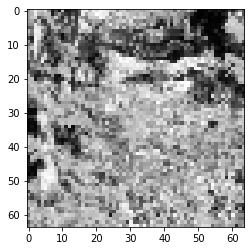

In [ ]:
# show some images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if len(npimg.shape) > 2:
        npimg = np.transpose(img, [1, 2, 0])
    plt.figure
    plt.imshow(npimg, 'gray')
    plt.show()
img, label = trainloader_small[0][0][11][0], trainloader_small[0][1][11]
label = int(np.array(label))
print(class_names[label])
imshow(img)

## Problem 1: Training a Network From Scratch
The days of hand designed features are gone. Now we have end-to-end learning in which a highly non-linear representation is learned for our data to maximize our objective function (in this case, 16-way classification accuracy). Let's start!

First, let's define a sample network architecture.

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class TNet(nn.Module):
    def __init__(self):
      super(TNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.classifier(x)
      return x  
  

Then, let's define model training and evaluation functions.

In [ ]:
#--------------------------------------------------
#       Model Training Function
#--------------------------------------------------
import torch.optim as optim
import time
  
def trainModel(net, trainloader, train_option, testloader=None):  
  loss_func = nn.CrossEntropyLoss()
  lr = train_option['lr']
  epoch = train_option['epoch']
  device = train_option['device'] if 'device' in train_option.keys() else 'cpu'
  log_iter = train_option['log_iter'] if 'log_iter' in train_option.keys() else 20
  eval_epoch = 1
  
  if 'optimizer' in train_option.keys():
    optimizer = train_option['optimizer']
  else:
    optimizer = optim.Adam(net.parameters(), lr=lr)

  start_time = time.time()
  if device == 'gpu':
    net = net.cuda()
    
  iters = 0
  running_loss = 0.0
  for ep in range(epoch):
    net.train()        
    for iter, (x, y) in enumerate(trainloader):
      iters += 1
      batch_x = Variable(x).float()
      batch_y = Variable(y).long()
      if device == 'gpu':
        batch_x = batch_x.cuda()
        batch_y = batch_y.cuda()

      outputs = net(batch_x)
      loss = loss_func(outputs, batch_y)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      running_loss += loss.item()
      
      time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))
      if iter % log_iter == 0:
        print('Epoch:{:2d} | Iter:{:5d} | Time: {} | Train Loss: {:.4f} | Average Loss: {:.4f} '.format(ep+1, iter, time_lapse, loss.item(), running_loss/iters))
   
    if testloader is not None and ep % eval_epoch == 0:
      evalModel(net, testloader)


In [ ]:
#--------------------------------------------------
#       Model Evaluating Function
#--------------------------------------------------
import time
  
def evalModel(net, testloader): 
  acc = 0.0
  count = 0
  start_time = time.time()
  device = 'gpu' if next(net.parameters()).is_cuda else 'cpu'
  net.eval()
  
  for iter, (x, y) in enumerate(testloader):
        count += x.shape[0]
        batch_x = Variable(x).float()
        batch_y = Variable(y).long()
        if device == 'gpu':
          batch_x = batch_x.cuda()
          batch_y = batch_y.cuda()
        outputs = net(batch_x)
        acc += torch.sum(outputs.max(1)[1]==batch_y)
        
  time_lapse = time.strftime('%H:%M:%S', time.gmtime(time.time() - start_time))        
  print('Accuracy: {:5f} | Time: {}'.format(acc/count,time_lapse))
  

Finally, let's start training and evaluation.

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = TNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 20
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:11 | Train Loss: 2.7627 | Average Loss: 2.7627 
Epoch: 1 | Iter:   20 | Time: 00:00:11 | Train Loss: 2.2525 | Average Loss: 2.6243 
Accuracy: 0.354167 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:11 | Train Loss: 1.6047 | Average Loss: 2.4335 
Epoch: 2 | Iter:   20 | Time: 00:00:11 | Train Loss: 1.6435 | Average Loss: 2.2250 
Accuracy: 0.367188 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:11 | Train Loss: 1.2634 | Average Loss: 2.1128 
Epoch: 3 | Iter:   20 | Time: 00:00:12 | Train Loss: 1.3049 | Average Loss: 1.9752 
Accuracy: 0.403646 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:12 | Train Loss: 0.9898 | Average Loss: 1.8850 
Epoch: 4 | Iter:   20 | Time: 00:00:12 | Train Loss: 1.0232 | Average Loss: 1.7776 
Accuracy: 0.440104 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:12 | Train Loss: 0.7996 | Average Loss: 1.7025 
Epoch: 5 | Iter:   20 | Time: 00:00:12 | Train Loss: 0.7969 | Average Loss: 1.6141 
Accuracy: 0.4453

Great! You would get around 0.45-0.50 accuracy by this very simple network. Now it's your job to beat this result.

### Problem 1.1
(35 points) Try to boost the accuracy by doing the following steps:

**Data Augmentation**: We don't have enough training data, let's augment the training data.
If you **left-right flip (mirror) an image** of a scene, it never changes categories. A kitchen doesn't become a forest when mirrored. This isn't true in all domains — a "d" becomes a "b" when mirrored, so you can't "jitter" digit recognition training data in the same way. But we can synthetically increase our amount of training data by left-right mirroring training images during the learning process.

After you implement mirroring, you should notice that your training error doesn't drop as quickly. That's actually a good thing, because it means the network isn't overfitting to the 2,400 original training images as much (because it sees 4,800 training images now, although they're not as good as 4,800 truly independent samples). Because the training and test errors fall more slowly, you may need more training epochs or you may try modifying the learning rate. You are **required** to implement mirroring as data augmentation for this part.

You can try more elaborate forms of jittering -- zooming in a random amount, rotating a random amount, taking a random crop, etc. These are not required, you might want to try these in the bonus part.

**Data Normalization**: The images aren't **zero-centered**. One simple trick which can help a lot is to subtract the mean from every image. It would arguably be more proper to only compute the mean from the training images (since the test/validation images should be strictly held out) but it won't make much of a difference. This part is **required**.

**Network Regularization**: Add **dropout layer**. If you train your network (especially for more than the default 30 epochs) you'll see that the training error can decrease to zero while the val top1 error hovers at 40% to 50%. The network has learned weights which can perfectly recognize the training data, but those weights don't generalize to held out test data. The best regularization would be more training data but we don't have that. Instead we will use dropout regularization.

What does dropout regularization do? It randomly turns off network connections at training time to fight overfitting. This prevents a unit in one layer from relying too strongly on a single unit in the previous layer. Dropout regularization can be interpreted as simultaneously training many "thinned" versions of your network. At test, all connections are restored which is analogous to taking an average prediction over all of the "thinned" networks. You can see a more complete discussion of dropout regularization in this [paper](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf).

The dropout layer has only one free parameter — the dropout rate — the proportion of connections that are randomly deleted. The default of 0.5 should be fine. Insert a dropout layer between your convolutional layers. In particular, insert it directly before your last convolutional layer (and try others if that helps). Your train accuracy should decrease much more slowly. That's to be expected — you're making life much harder for the training algorithm by cutting out connections randomly. In this part, you are **required** to add dropout layer to your network.

**Please give detailed descriptions of your network layout in the following format:**<br>
Data augmentation: [descriptions]<br>
Data normalization: [descriptions]<br>
Layer 1: [layer_type]: [Parameters]<br>
Layer 2: [layer_type]: [Parameters]<br>
...<br>
**Then report the final accuracy on test set.**

The minimum accuracy required for this section is **0.55**.

In [ ]:
# load data into size (64, 64)
img_size = (64, 64)
batch_size = 64 # training sample number per batch

# load training dataset
trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class HorNet(nn.Module):
    def __init__(self):
      super(HorNet,self).__init__()  
           
      self.features = torch.nn.Sequential(
        nn.Conv2d(1, 16, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4), 
      )
      self.dropout = nn.Dropout(0.25)
      self.classifier = nn.Sequential(
         nn.Linear(3600, 16), 
      )
      
      
    def forward(self, x):
      x = self.features(x)  
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier(x)
      return x  


In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = HorNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 60
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7972 | Average Loss: 2.7972 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.4560 | Average Loss: 2.7793 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.3140 | Average Loss: 2.5644 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 1.9877 | Average Loss: 2.4214 
Accuracy: 0.424479 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.6555 | Average Loss: 2.3226 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.7599 | Average Loss: 2.2025 
Epoch: 2 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.8155 | Average Loss: 2.1199 
Epoch: 2 | Iter:   60 | Time: 00:00:00 | Train Loss: 1.5069 | Average Loss: 2.0522 
Accuracy: 0.437500 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:00 | Train Loss: 1.2804 | Average Loss: 1.9955 
Epoch: 3 | Iter:   20 | Time: 00:00:00 | Train Loss: 1.4766 | Average Loss: 1.9268 
Epoch: 3 | Iter:   40 | Time: 00:00:00 | Train Loss: 1.5170 | Average Loss: 1.8745 
Epoc

**Answer**:

Data augmentation: The image is flipped horizontally to get the augmented image

Data normalization: First we calculated the mean and then subtracted from the image, which resulted in zero-centered image

Layer 1: Same as the sample network given. It has 16 output channels. This is followed by ReLU activation and MaxPooling layers

Layer 2: NN layer with 3600 input node and 16 output nodes. Dropout with p=0.25 was also added before this


...

Accuray on test set: **0.580729** (best epoch)


## Problem 1.2

(15 points) Try **three different techniques** taught in the class to increase the accuracy of your model. Such as increasing training data by randomly rotating training images, adding batch normalization, different activation functions (e.g., sigmoid) and model architecture modification. Note that too many layers can do you no good due to insufficient training data. Clearly describe your method and accuracy increase/decrease for each of the three techniques.

The minimum accuracy required for this section is **0.60**. (At least one Technique should achieve this)

### Technique 1

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)

batch_size = 64         # training sample number per batch

# load training dataset

trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=False, zero_centered=True))
train_num = len(trainloader_small)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))
test_num = len(testloader_small)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class HorNet(nn.Module):
    def __init__(self):
      super(HorNet,self).__init__()  
           
      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.ReLU(),
        nn.MaxPool2d(4, stride=4)
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2) 
      )

      self.dropout = nn.Dropout(0.25)      
      
      self.classifier = nn.Sequential(
         nn.Linear(4608, 16) 
      )

      
    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)  
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier(x)
      return x  


In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = HorNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 60
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8616 | Average Loss: 2.8616 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.7089 | Average Loss: 3.4855 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.7013 | Average Loss: 3.1113 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.6393 | Average Loss: 2.9663 
Accuracy: 0.156250 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7103 | Average Loss: 2.9073 
Epoch: 2 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.5134 | Average Loss: 2.8415 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.5171 | Average Loss: 2.7921 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 2.2950 | Average Loss: 2.7389 
Accuracy: 0.226562 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.4205 | Average Loss: 2.6952 
Epoch: 3 | Iter:   20 | Time: 00:00:01 | Train Loss: 1.9993 | Average Loss: 2.6368 
Epoch: 3 | Iter:   40 | Time: 00:00:01 | Train Loss: 1.9628 | Average Loss: 2.5823 
Epoc

**Answer**:

Technique 1: Network architecture modification

Data augmentation: No augmentation

Data normalization: First we calculated the mean and then subtracted from the image, which resulted in zero-centered image

Layer 1: Convolution layer with 16 output channels, followed by ReLU activation and MaxPooling layer

Layer 2: Convolution layer with 128 output channels, followed by Sigmoid activation and MaxPooling layer

Layer 3: NN layer with 4608 input node and 16 output nodes. Dropout with p=0.25 was also added before this

Accuracy on test set: **0.669271**

Accuracy increases/decreases: Increase

### Technique 2

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)

batch_size = 64         # training sample number per batch

# load training dataset

trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=False, zero_centered=True))
train_num = len(trainloader_small)

print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset

testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))

test_num = len(testloader_small)

print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class HorNet(nn.Module):
    def __init__(self):
      super(HorNet,self).__init__()  
           
      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.BatchNorm2d(64),
        nn.Tanh(),
        nn.MaxPool2d(4, stride=4), 
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2), 
      )
      
      self.classifier1 = nn.Sequential(
         nn.Linear(4608, 1024), 
         nn.BatchNorm1d(1024),
         nn.LeakyReLU()
      )
      self.classifier2 = nn.Sequential(
         nn.Linear(1024, 16),
         nn.BatchNorm1d(16),
         nn.Sigmoid()
      )

      self.dropout = nn.Dropout(0.5)
      
    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)  
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier1(x)
      x = self.classifier2(x)
      return x  



In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = HorNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 60
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8015 | Average Loss: 2.8015 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.6417 | Average Loss: 2.6768 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.5648 | Average Loss: 2.6413 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.5413 | Average Loss: 2.6206 
Accuracy: 0.346354 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.5513 | Average Loss: 2.6063 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.4973 | Average Loss: 2.5909 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.4628 | Average Loss: 2.5758 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 2.4301 | Average Loss: 2.5623 
Accuracy: 0.476562 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:02 | Train Loss: 2.4867 | Average Loss: 2.5521 
Epoch: 3 | Iter:   20 | Time: 00:00:02 | Train Loss: 2.4115 | Average Loss: 2.5400 
Epoch: 3 | Iter:   40 | Time: 00:00:02 | Train Loss: 2.4198 | Average Loss: 2.5283 
Epoc

**Answer**:

Technique 2: Different activation function (Sigmoid, Leaky ReLU, tanh)

Data augmentation: No augmentation done

Data normalization: First we calculated the mean and then subtracted from the image, which resulted in zero-centered image

Layer 1: Convolution layer with 64 output channels, followed by batchnormalization, tanh activation and MaxPooling layer

Layer 2: Convolution layer with 128 output channels, followed by Sigmoid activation and MaxPooling layer

Layer 3: NN layer with 4608 input node and 1024 output nodes. Batchnormalization and LeakyReLU is also added.

Layer 4: NN layer with 1024 input and 16 output nodes. This is followed by batchnormalization and sigmoid activation. Dropout with p=0.5 was also added before this


Accuracy on test set: **0.729167**

Accuracy increases/decreases: Increase

### Technique 3

In [ ]:
#--------------------------------------------------
#    Load Training Data and Testing Data
#--------------------------------------------------
# load data into size (64, 64)
img_size = (64, 64)

batch_size = 64         # training sample number per batch

# load training dataset

trainloader_small = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, augment=True, zero_centered=True))
train_num = len(trainloader_small)

print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset

testloader_small = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, zero_centered=True))

test_num = len(testloader_small)

print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))


Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 75 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Define Network Architecture
#--------------------------------------------------
class HorNet(nn.Module):
    def __init__(self):
      super(HorNet,self).__init__()  
           
      self.layer1 = torch.nn.Sequential(
        nn.Conv2d(1, 64, 3),
        nn.BatchNorm2d(64),
        nn.Tanh(),
        nn.MaxPool2d(4, stride=4)
      )
      self.layer2 = torch.nn.Sequential(
        nn.Conv2d(64, 128, 3),
        nn.BatchNorm2d(128),
        nn.Sigmoid(),
        nn.MaxPool2d(2, stride=2)
      )
      
      self.classifier1 = nn.Sequential(
         nn.Linear(4608, 1024), 
         nn.BatchNorm1d(1024),
         nn.LeakyReLU()
      )
      self.classifier2 = nn.Sequential(
         nn.Linear(1024, 16),
         nn.BatchNorm1d(16),
         nn.Sigmoid()
      )

      self.dropout = nn.Dropout(0.5)
      
    def forward(self, x):
      x = self.layer1(x)
      x = self.layer2(x)  
      x = torch.flatten(x, 1)
      x = self.dropout(x)
      x = self.classifier1(x)
      x = self.classifier2(x)
      return x  



In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = HorNet() 
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 60
train_option['device'] = 'gpu'
trainModel(net, trainloader_small, train_option, testloader_small)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.7984 | Average Loss: 2.7984 
Epoch: 1 | Iter:   20 | Time: 00:00:00 | Train Loss: 2.5673 | Average Loss: 2.6438 
Epoch: 1 | Iter:   40 | Time: 00:00:00 | Train Loss: 2.5484 | Average Loss: 2.6119 
Epoch: 1 | Iter:   60 | Time: 00:00:00 | Train Loss: 2.5119 | Average Loss: 2.5904 
Accuracy: 0.419271 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.4945 | Average Loss: 2.5755 
Epoch: 2 | Iter:   20 | Time: 00:00:01 | Train Loss: 2.4561 | Average Loss: 2.5582 
Epoch: 2 | Iter:   40 | Time: 00:00:01 | Train Loss: 2.4330 | Average Loss: 2.5437 
Epoch: 2 | Iter:   60 | Time: 00:00:01 | Train Loss: 2.4514 | Average Loss: 2.5312 
Accuracy: 0.494792 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:02 | Train Loss: 2.4043 | Average Loss: 2.5212 
Epoch: 3 | Iter:   20 | Time: 00:00:02 | Train Loss: 2.4014 | Average Loss: 2.5096 
Epoch: 3 | Iter:   40 | Time: 00:00:02 | Train Loss: 2.3859 | Average Loss: 2.4981 
Epoc

**Answer**:

Technique 3: Augmentation with deeper network and batchnormalization

Data augmentation: Horizontal flipping

Data normalization: First we calculated the mean and then subtracted from the image, which resulted in zero-centered image

Layer 1: Convolution layer with 64 output channels, followed by batchnormalization, tanh activation and MaxPooling layer

Layer 2: Convolution layer with 128 output channels, followed by batchnormalization, Sigmoid activation and MaxPooling layer

Layer 3: NN layer with 4608 input node and 1024 output nodes. Batchnormalization and LeakyReLU is also added.

Layer 4: NN layer with 1024 input and 16 output nodes. This is followed by batchnormalization and sigmoid activation. Dropout with p=0.5 was also added before this

Accuracy on test set: **0.752604**

Accuracy increases/decreases:

## Problem 2: Fine Tuning a Pre-Trained Deep Network
Our convolutional network to this point isn't "deep". Fortunately, the representations learned by deep convolutional networks is that they generalize surprisingly well to other recognition tasks. 

But how do we use an existing deep network for a new recognition task? Take for instance,  [AlexNet](http://papers.nips.cc/paper/4824-imagenet-classification-with-deep-convolutional-neural-networks) network has 1000 units in the final layer corresponding to 1000 ImageNet categories.


**Hints**:
- Many pre-trained models are available in PyTorch at [here](http://pytorch.org/docs/master/torchvision/models.html).
- For fine-tuning pretrained network using PyTorch, please read this [tutorial](http://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html).

### Problem 2.1

**Strategy A**: *Fine-tune* an existing network. In this scenario you take an existing network, replace the final layer (or more) with random weights, and train the entire network again with images and ground truth labels for your recognition task. You are effectively treating the pre-trained deep network as a better initialization than the random weights used when training from scratch. When you don't have enough training data to train a complex network from scratch (e.g. with the 16 classes) this is an attractive option. Fine-tuning can work far better than Strategy B of taking the activations directly from an pre-trained CNN. For example, in [this paper](http://www.cc.gatech.edu/~hays/papers/deep_geo.pdf) from CVPR 2015, there wasn't enough data to train a deep network from scratch, but fine tuning led to 4 times higher accuracy than using off-the-shelf networks directly.

(25 points) You are required to implement Strategy A to fine-tune a pre-trained **AlexNet** for this scene classification task. You should be able to achieve accuracy of **0.85** approximately. The minimum accuracy required for this section is **0.75**.

Please provide detailed descriptions of:<br>
(1) which layers of AlexNet have been replaced<br>
(2) the architecture of the new layers added including activation methods (same as problem 1)<br>
(3) the final accuracy on test set <br>

In [ ]:
# reload data with a larger size
img_size = (224, 224)
batch_size = 64 # training sample number per batch 

# load training dataset
trainloader_large = list(load_dataset('./data/train/', img_size, batch_size=batch_size, shuffle=True, 
                                      augment=False, is_color=True, zero_centered=True))
train_num = len(trainloader_large)
print("Finish loading %d minibatches (batch_size=%d) of training samples." % (train_num, batch_size))

# load testing dataset
testloader_large = list(load_dataset('./data/test/', img_size, num_per_class=50, batch_size=batch_size, is_color=True, zero_centered=True))
test_num = len(testloader_large)
print("Finish loading %d minibatches (batch_size=%d) of testing samples." % (test_num, batch_size))

Loading images from class: 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 37 minibatches (batch_size=64) of training samples.
Loading images from class: 0
Loading images from class: 1
Loading images from class: 2
Loading images from class: 3
Loading images from class: 4
Loading images from class: 5
Loading images from class: 6
Loading images from class: 7
Loading images from class: 8
Loading images from class: 9
Loading images from class: 10
Loading images from class: 11
Loading images from class: 12
Loading images from class: 13
Loading images from class: 14
Loading images from class: 15
Finish loading 6 minib

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
from torchvision import models
pretrained_net = models.alexnet(pretrained = True)


class Iden(nn.Module):
  def __init__(self):
    super(Iden,self).__init__()

  def forward(self,x):
    return x



class HorNet(nn.Module):
    def __init__(self):
      super(HorNet,self).__init__()  
           
      self.classifier = nn.Sequential(
          nn.Dropout(0.25),
          nn.Linear(9216, 4096), 
          nn.BatchNorm1d(4096),
          nn.ReLU(),
          nn.Dropout(0.25),
          nn.Linear(4096, 1024),
          nn.ReLU(),
          nn.Dropout(0.5),
          nn.Linear(1024,16),
      )
      
    def forward(self, x):
      x = self.classifier(x)
      return x  

pretrained_net.avgpool = Iden()
pretrained_net.classifier = HorNet()

In [ ]:
#--------------------------------------------------
#       Start Training & Evaluation
#--------------------------------------------------
net = pretrained_net
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 40
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainModel(net, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:00 | Train Loss: 2.8407 | Average Loss: 2.8407 
Epoch: 1 | Iter:   20 | Time: 00:00:02 | Train Loss: 0.8601 | Average Loss: 1.9679 
Accuracy: 0.763021 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:04 | Train Loss: 0.6591 | Average Loss: 1.4353 
Epoch: 2 | Iter:   20 | Time: 00:00:05 | Train Loss: 0.4108 | Average Loss: 1.1207 
Accuracy: 0.752604 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:07 | Train Loss: 0.3808 | Average Loss: 0.9646 
Epoch: 3 | Iter:   20 | Time: 00:00:09 | Train Loss: 0.2062 | Average Loss: 0.8241 
Accuracy: 0.802083 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:00:11 | Train Loss: 0.1794 | Average Loss: 0.7350 
Epoch: 4 | Iter:   20 | Time: 00:00:13 | Train Loss: 0.0879 | Average Loss: 0.6487 
Accuracy: 0.812500 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:00:15 | Train Loss: 0.2642 | Average Loss: 0.5917 
Epoch: 5 | Iter:   20 | Time: 00:00:17 | Train Loss: 0.0465 | Average Loss: 0.5345 
Accuracy: 0.8359

**Answer**:

(1) which layers of AlexNet have been replaced

The global avg. pooling layer and the final classification layer

(2) the architecture of the new layers added including activation methods (same as problem 1)

Data augmentation: Yes

Data normalization: Yes

Features Layers : 

(features): Sequential(
  
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))

    (1): ReLU(inplace=True)

    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)

    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))

    (4): ReLU(inplace=True)

    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    
    (7): ReLU(inplace=True)
    
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    
    (9): ReLU(inplace=True)
    
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    
    (11): ReLU(inplace=True)
    
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  
Classifier Layer: 

  (classifier): HorNet(
    
    (classifier): Sequential(
      (0): Dropout(p=0.25, inplace=False)
      (1): Linear(in_features=9216, out_features=4096, bias=True)
      (2): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReLU()
      (4): Dropout(p=0.25, inplace=False)
      (5): Linear(in_features=4096, out_features=1024, bias=True)
      (6): ReLU()
      (7): Dropout(p=0.5, inplace=False)
      (8): Linear(in_features=1024, out_features=16, bias=True)
    )
  )


(3) the final accuracy on test set

Accuracy on test set: **0.861979**



### Problem 2.2
**Strategy B**: One could use those 1000 activations as a feature in place of a hand crafted feature such as a bag-of-features representation. You would train a classifier (typically a linear SVM) in that 1000 dimensional feature space. However, those activations are clearly very object specific and may not generalize well to new recognition tasks. It is generally better to use the activations in slightly earlier layers of the network, e.g. the 4096 activations in the last 2nd fully-connected layer. You can often get away with sub-sampling those 4096 activations considerably, e.g. taking only the first 1000 activations.

(25 points) Implement Strategy B where you use the activations of the pre-trained **AlexNet** as features to train **one-vs-all SVMs** for your scene classification task. Report the final accuracy on test set. You should be able to achieve accuracy of **0.80** approximately. The minimum accuracy required for this section is **0.70**.

In [ ]:
#--------------------------------------------------
#       Get Features from AlexNet
#--------------------------------------------------
def get_features(model , dataset):
  
  act = {}
  feature_train = None
  label_train = None
  def activation(name):
    def hook(model, input, output):
        act[name] = output.detach()
    return hook

  model.classifier[5].register_forward_hook(activation('ReLU_layer'))

  model = model.cuda()
  for iter, (i, l) in enumerate(dataset):
    i_batch = Variable(i).float().cuda()
    l_batch = Variable(l).long().cuda()
    
    outputs = model(i_batch)
    if feature_train is None :
      feature_train = act[ 'ReLU_layer' ][:,:1000]
      label_train = l_batch
    else :
      feature_train = torch.vstack((feature_train, act['ReLU_layer'][:,:1000]))
      label_train = torch.vstack((label_train,l_batch))
  
  label_train = label_train.view(-1,1)
  
  return feature_train, label_train

pretrained_net = models.alexnet(pretrained=True)

train_feat, train_label = get_features(pretrained_net, trainloader_large)
test_feat, test_label = get_features(pretrained_net, testloader_large)


/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
#--------------------------------------------------
#       Train and Evaluate SVM
#--------------------------------------------------
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import LinearSVC
train_feat, train_label = train_feat.detach().cpu().numpy() ,train_label.detach().cpu().numpy().ravel()
test_feat, test_label = test_feat.detach().cpu().numpy() ,test_label.detach().cpu().numpy().ravel()

clf = OneVsOneClassifier(LinearSVC(random_state=0)).fit(train_feat, train_label)

pred = [-1]*len(test_feat)
for k in range(len(test_feat)):
  pred[k] = clf.predict(np.reshape(test_feat[k],(1,-1)))

test_pred = np.reshape(np.array(pred),(-1,))

acc = sum(np.array(test_pred) == test_label) / float(len(test_label))
print("SVM accuracy {:.2f}%".format(acc*100))

SVM accuracy 75.00%


**Answer**:

Accuracy on test set: **75.00%**

### Problem 2.3 (Bonus)

(Bonus: 10 points) Bonus will be given to those who fine-tune the [ResNet network](https://pytorch.org/docs/stable/_modules/torchvision/models/resnet.html) [(paper)](https://arxiv.org/abs/1512.03385) and compare performance with AlexNet. Explain why ResNet performed better or worse. You are **required** to use **resnet50** model. You should be able to achieve accuracy of **0.99** approximately. The minimum accuracy required for this section is **0.85**.

In [ ]:
#--------------------------------------------------
#       Fine-Tune Pretrained Network
#--------------------------------------------------
pretrained_net = models.resnet50(pretrained = True)
pretrained_net.fc = nn.Sequential(nn.BatchNorm1d(2048),
                         nn.Dropout(0.5),
                         nn.Linear(2048,1000,bias=True),
                         nn.ReLU(),
                         nn.Linear(1000,16))

net = pretrained_net
train_option = {}
train_option['lr'] = 0.002
train_option['epoch'] = 40
train_option['device'] = 'gpu'
train_option['optimizer'] = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
trainModel(net, trainloader_large, train_option, testloader_large)

Epoch: 1 | Iter:    0 | Time: 00:00:01 | Train Loss: 2.8661 | Average Loss: 2.8661 
Epoch: 1 | Iter:   20 | Time: 00:00:14 | Train Loss: 0.2724 | Average Loss: 1.5355 
Accuracy: 0.841146 | Time: 00:00:00
Epoch: 2 | Iter:    0 | Time: 00:00:26 | Train Loss: 0.2188 | Average Loss: 1.0158 
Epoch: 2 | Iter:   20 | Time: 00:00:39 | Train Loss: 0.1807 | Average Loss: 0.7575 
Accuracy: 0.820312 | Time: 00:00:00
Epoch: 3 | Iter:    0 | Time: 00:00:52 | Train Loss: 0.1598 | Average Loss: 0.6136 
Epoch: 3 | Iter:   20 | Time: 00:01:05 | Train Loss: 0.0158 | Average Loss: 0.5024 
Accuracy: 0.898438 | Time: 00:00:00
Epoch: 4 | Iter:    0 | Time: 00:01:18 | Train Loss: 0.0213 | Average Loss: 0.4322 
Epoch: 4 | Iter:   20 | Time: 00:01:31 | Train Loss: 0.0043 | Average Loss: 0.3712 
Accuracy: 0.921875 | Time: 00:00:00
Epoch: 5 | Iter:    0 | Time: 00:01:44 | Train Loss: 0.0423 | Average Loss: 0.3310 
Epoch: 5 | Iter:   20 | Time: 00:01:58 | Train Loss: 0.0016 | Average Loss: 0.2938 
Accuracy: 0.8984

**Answer**:

Accuracy on test set: **0.929688**


## Submission guidelines
---
We will grade your homework based on your submitted notebook file. We will check the notebook for both results and code. Please make sure you run your code and print out the results in the notebook before submitting (we expect to see the results before running your code by ourselves.)

You submit your homework by first creating a ***google shared link*** of a folder for your homework (described below), and put that link into the ***text submission section*** of your homework submission on Blackboard. ([How to submit your link?](https://drive.google.com/file/d/16-FlPSiu5n-pRezLfcbAvgYxXtGtrs16))

To generate the ***google shared link***, first create a folder named ***Surname_Givenname_SBUID_hw**** in your Google Drive with your CS account (or your SBU account if you don't have a CS account). The structure of the files in the folder should be exactly the same as the one you downloaded. For instance in this homework:

```
Surname_Givenname_SBUID_hw4
        |---CSE527-22F-HW4.ipynb
```
Note that this folder should be in your Google Drive with your account.

Then right click this folder, click ***Get shareable link***, in the People textfield, enter the TAs' email: ***haoyuwu@cs.stonybrook.edu*** and ***vhnguyen@cs.stonybrook.edu***. Make sure that the TAs who have the link **can edit**, ***not just*** **can view**, and also **uncheck** the **Notify people** box. ([How to share link?](https://drive.google.com/file/d/17R6j6yE8_8vXioOB3nNvbEPzxcI-rr_H) )

***IMPORTANT: Please do not make any modification to the folder and its files after the submission deadline***. (All modifications can be seen by the TAs via the revision history.) Note that in google colab, we will only grade the version of the code right before the timestamp of the submission made in blackboard.

The input and output paths are predefined and **DO NOT** change them, (we assume that 'Surname_Givenname_SBUID_hw1' is your working directory, and all the paths are relative to this directory).  The image read and write functions are already written for you. All you need to do is to fill in the blanks as indicated to generate proper outputs.


-- DO NOT change the folder structure, please just fill in the blanks. <br>

You are encouraged to post and answer questions on Piazza. Based on the amount of email that we have received in past years, there might be delays in replying to personal emails. Please ask questions on Piazza and send emails only for personal issues.

If you alter the folder structures, the grading of your homework will be significantly delayed and possibly penalized.

Be aware that your code will undergo plagiarism check both vertically and horizontally. Please do your own work.

Late submission penalty: <br>
There will be a 10% penalty per day for late submission. However, you will have 4 days throughout the whole semester to submit late without penalty. Note that the grace period is calculated by days instead of hours. If you submit the homework one minute after the deadline, one late day will be counted. Likewise, if you submit one minute after the deadline, the 10% penaly will be imposed if not using the grace period.


<!--Write your report here in markdown or html-->
